In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout, ReLU,Softmax
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model

from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 512
epochs = 300
batch_size = 64

In [3]:
train_data_path = 'train_data_uint8_512_vcm_discrinimator_alpha.npy'
test_data_path = 'real_data_uint8_512_vcm_10000_alpha.npy'
train_label_path = 'train_label_uint8_512_vcm_discrinimator_alpha.npy'
test_label_path = 'real_label_uint8_512_vcm_10000_alpha.npy'

In [4]:
train_data = np.load(train_data_path)#[:2000, :, :, :]
test_data = np.load(test_data_path)
train_label = np.load(train_label_path)#[:2000, :]
test_label = np.load(test_label_path)
# test_label = (abs(test_label[:, 0] - test_label[:, 1]) <= 33)

In [ ]:
# train_data = data[:10000, :, :, :]
# train_label = label[:10000, :]

[1. 1. 1.]


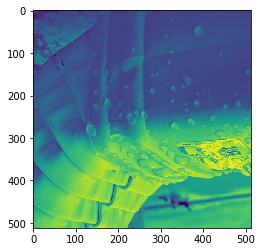

In [ ]:
#to_categorical(train_label[:, 2]).shape
import matplotlib.pyplot as plt
%matplotlib inline
idx = 2
plt.imshow(train_data[idx, :, :, 0])

print(train_label[idx, :])

[1. 1. 1.]


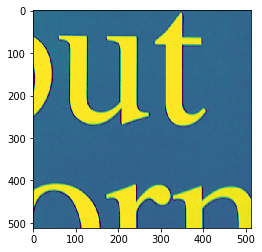

In [ ]:
plt.imshow(test_data[idx, :, :, 0])

print(test_label[idx])

In [ ]:
# In[7]:
input_image1 = Input(shape=(512,512,1), name = "input")
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(1, (8, 8), 8,padding='same',activation=relu, name="Conv1_1")(input_image1)

layer2_1 = Conv2D(1, (8, 8), 8,padding='same',activation=relu, name="Conv2_1")(layer1_1)

#layer3_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv3_1")(layer2_1)

#layer4_1 = Conv2D(32, (3, 3), 2,padding='same',activation=relu, name="Conv4_1")(layer3_1)

flattened = Flatten(name="flat")(layer2_1)

dense1 = Dense(10, name="d1")(flattened)
Dp1 = Dropout(0.5)(dense1)
#ReLU1 = ReLU(name="lr1")(dense1)

output_position = Dense(2, activation='softmax', name="out")(Dp1)

print(output_position)

model = Model(inputs=input_image1, outputs=output_position)
model.summary()

tcbc = TensorBoard(log_dir='1')

filepath="models/dis_train_on_generate/n_weights-{epoch:03d}-{val_acc:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, save_weights_only=True,mode='max',period=2)


print(model.output_shape)

Tensor("out/Softmax:0", shape=(?, 2), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 1)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 64, 64, 1)         65        
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 8, 8, 1)           65        
_________________________________________________________________
flat (Flatten)               (None, 64)                0         
_________________________________________________________________
d1 (Dense)                   (None, 10)                650       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
out (Dense)            

In [ ]:
def data_gen(features, labels, batch_size):
    while True:
        for i in np.arange(0, features.shape[0] - batch_size, batch_size):
            # choose random index in features
            batch_features = features[i:i+batch_size, :, :, :].astype('float16')/255.0
            batch_labels = labels[i:i+batch_size, :]
            yield (batch_features, batch_labels)

In [ ]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

# model.fit(train_data[:,:,:,0:1].astype('float16')/255.0, to_categorical(train_label[:, 2:]), 
#           epochs = 100,batch_size = batch_size,
#           validation_data=(test_data[:,:,:,0:1].astype('float16')/255.0, to_categorical(test_label)), 
#           verbose=1, callbacks = [tcbc, checkpoint])

In [ ]:
model.fit_generator(data_gen(train_data, to_categorical(train_label[:, 2:]), batch_size), 
                    steps_per_epoch = train_data.shape[0]/batch_size, epochs = epochs,
                    validation_data=data_gen(test_data, to_categorical(test_label[:, 2:]), batch_size), 
                    validation_steps = batch_size,
                    verbose=1, callbacks = [tcbc, checkpoint])

Epoch 1/300
157/156 [==============================] - 42s 270ms/step - loss: 0.5938 - acc: 0.6679 - val_loss: 0.4783 - val_acc: 0.8521
Epoch 2/300
156/156 [============================>.] - ETA: 0s - loss: 0.3769 - acc: 0.8648
Epoch 00002: saving model to models/dis_train_on_generate/n_weights-002-0.911.h5
157/156 [==============================] - 40s 258ms/step - loss: 0.3758 - acc: 0.8652 - val_loss: 0.3404 - val_acc: 0.9106
Epoch 3/300
157/156 [==============================] - 40s 258ms/step - loss: 0.3145 - acc: 0.8847 - val_loss: 0.3185 - val_acc: 0.9163
Epoch 4/300
156/156 [============================>.] - ETA: 0s - loss: 0.2957 - acc: 0.8913
Epoch 00004: saving model to models/dis_train_on_generate/n_weights-004-0.906.h5
157/156 [==============================] - 40s 258ms/step - loss: 0.2959 - acc: 0.8913 - val_loss: 0.3236 - val_acc: 0.9065
Epoch 5/300
157/156 [==============================] - 40s 258ms/step - loss: 0.2800 - acc: 0.8963 - val_loss: 0.3009 - val_acc: 0.915

Epoch 39/300
157/156 [==============================] - 41s 258ms/step - loss: 0.1620 - acc: 0.9467 - val_loss: 0.4915 - val_acc: 0.7480
Epoch 40/300
156/156 [============================>.] - ETA: 0s - loss: 0.1560 - acc: 0.9481
Epoch 00040: saving model to models/dis_train_on_generate/n_weights-040-0.748.h5
157/156 [==============================] - 41s 258ms/step - loss: 0.1565 - acc: 0.9479 - val_loss: 0.4888 - val_acc: 0.7483
Epoch 41/300
157/156 [==============================] - 40s 258ms/step - loss: 0.1607 - acc: 0.9474 - val_loss: 0.5120 - val_acc: 0.7371
Epoch 42/300
156/156 [============================>.] - ETA: 0s - loss: 0.1585 - acc: 0.9467
Epoch 00042: saving model to models/dis_train_on_generate/n_weights-042-0.734.h5
157/156 [==============================] - 41s 259ms/step - loss: 0.1585 - acc: 0.9465 - val_loss: 0.5180 - val_acc: 0.7336
Epoch 43/300
157/156 [==============================] - 41s 259ms/step - loss: 0.1627 - acc: 0.9468 - val_loss: 0.5663 - val_acc: 

Epoch 77/300
157/156 [==============================] - 41s 258ms/step - loss: 0.1444 - acc: 0.9516 - val_loss: 0.5730 - val_acc: 0.7161
Epoch 78/300
156/156 [============================>.] - ETA: 0s - loss: 0.1437 - acc: 0.9515
Epoch 00078: saving model to models/dis_train_on_generate/n_weights-078-0.723.h5
157/156 [==============================] - 41s 258ms/step - loss: 0.1434 - acc: 0.9517 - val_loss: 0.5599 - val_acc: 0.7231
Epoch 79/300
157/156 [==============================] - 41s 258ms/step - loss: 0.1385 - acc: 0.9526 - val_loss: 0.5986 - val_acc: 0.7134
Epoch 80/300
156/156 [============================>.] - ETA: 0s - loss: 0.1429 - acc: 0.9557
Epoch 00080: saving model to models/dis_train_on_generate/n_weights-080-0.742.h5
157/156 [==============================] - 41s 258ms/step - loss: 0.1429 - acc: 0.9556 - val_loss: 0.5196 - val_acc: 0.7424
Epoch 81/300
157/156 [==============================] - 40s 258ms/step - loss: 0.1441 - acc: 0.9534 - val_loss: 0.6427 - val_acc: 

In [ ]:
# model.save('my_model_dis_512.h5')

# model.save_weights('my_dis_weights_512.h5')
# # model.load_weights('my_dis_weights_512.h5')

In [ ]:
# print(to_categorical(train_label[:10, 2:]))

In [ ]:
# pred  = model.predict(train_data[:, :, :, :50])

In [ ]:
# idx = 25
# plt.imshow(train_data[idx, :, :, 0])

# print(train_label[idx, :])
# print(pred[idx, :])